# Test models (exponential and q)

## Import library

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr

## Setting up directory

In [2]:
data_dir = "/home/waves/projects/smap-drydown/data"
datarods_dir = "datarods"
SMAPL3_dir = r"SPL3SMP"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
PET_dir = r"PET"

import getpass
username = getpass.getuser()
formatted_now = datetime.now().strftime("%Y-%m-%d")
output_dir = rf"/home/waves/projects/smap-drydown/output/fit_models_nb_{username}_{formatted_now}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

## Read coordinate information

### Define the coordinates

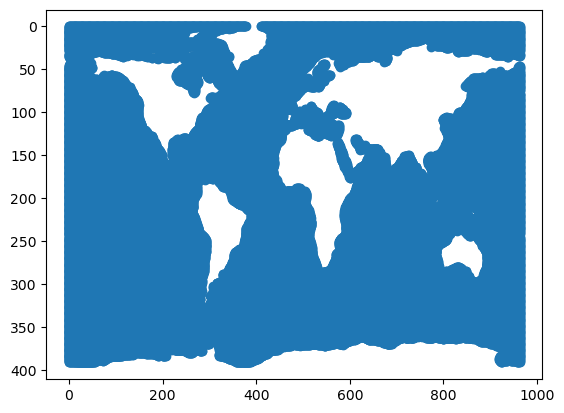

In [3]:
file_path = os.path.join(data_dir, datarods_dir, "coord_info.csv")
coord_info = pd.read_csv(file_path)
file_path = os.path.join(data_dir, datarods_dir, "coord_open_water.csv")
coord_open_water = pd.read_csv(file_path)
plt.scatter(coord_open_water.EASE_column_index, coord_open_water.EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

### Subset to CONUS bbox

In [4]:
min_lon = -125.000000
min_lat = 24.396308
max_lon = -66.934570
max_lat = 49.384358
_conus_subset = coord_info[(coord_info['latitude'] >= min_lat) &
                         (coord_info['latitude'] <= max_lat) &
                         (coord_info['longitude'] >= min_lon) &
                         (coord_info['longitude'] <= max_lon)].copy()

conus_subset = pd.merge(_conus_subset, coord_open_water, on=['EASE_row_index', 'EASE_column_index'], how='left', indicator=True).query('_merge == "left_only"').drop(columns='_merge')
print(len(conus_subset))

9596


## Sample a point

id                   95641.000000
latitude                30.638416
EASE_row_index          99.000000
longitude             -103.257260
EASE_column_index      205.000000
Name: 7858, dtype: float64


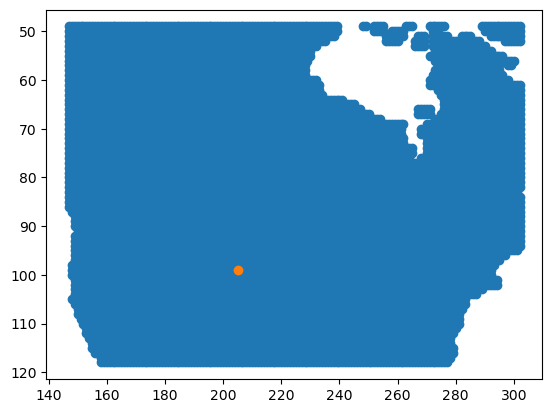

In [5]:
# SPECIFY THE INDEX (0, 9596)
p = 7000

# Plot the location
EASE_row_index = conus_subset.EASE_row_index.iloc[p].copy()
EASE_column_index = conus_subset.EASE_column_index.iloc[p].copy()
print(conus_subset.iloc[p])

# Plot 
plt.scatter(conus_subset.EASE_column_index, conus_subset.EASE_row_index)
plt.scatter(EASE_column_index, EASE_row_index)
ax = plt.gca()
ax.invert_yaxis()

## Load datasets

### SMAPL3 Soil mositure data

/home/waves/projects/smap-drydown/data/datarods/SPL3SMP/SPL3SMP_099_205.csv


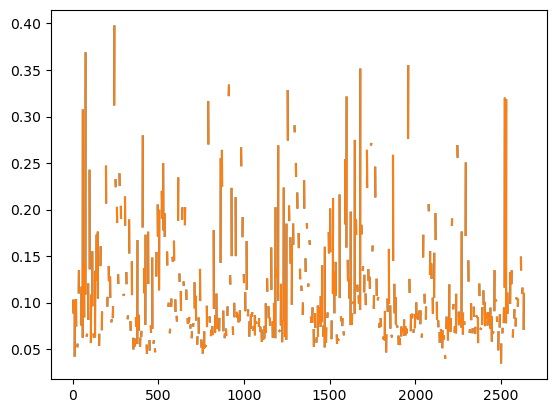

In [18]:
filename = os.path.join(data_dir, datarods_dir, SMAPL3_dir, f"SPL3SMP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df = pd.read_csv(filename)
df.Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm.plot()
df.Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm.plot()
print(filename)

In [19]:
# Set time index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()

,Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_PM_surface_flag_pm,Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag,Soil_Moisture_Retrieval_Data_AM_soil_moisture,Soil_Moisture_Retrieval_Data_AM_surface_flag
time,,,,,,
2015-03-31,7.0,NaN,2047.0,7.0,NaN,2047.0
2015-03-31,7.0,NaN,2047.0,7.0,NaN,2047.0
2015-04-01,7.0,NaN,2047.0,0.0,0.120143,0.0
2015-04-02,0.0,0.102110,0.0,7.0,NaN,2047.0
2015-04-03,0.0,0.089467,0.0,0.0,0.107347,0.0


In [20]:
# Use retrieval flag to quality control the data
condition_bad_data_am = (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)
condition_bad_data_pm = (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df['Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)
df.loc[condition_bad_data_am, 'Soil_Moisture_Retrieval_Data_AM_soil_moisture'] = np.nan
df.loc[condition_bad_data_pm, 'Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'] = np.nan

In [21]:
# There is two different versions of 2015-03-31 data --- remove this 
duplicate_labels = df.index.duplicated(keep=False)
df = df.loc[~df.index.duplicated(keep='first')]

In [22]:
# Resample to regular time interval
df = df.resample('D').asfreq()

In [23]:
# Check if the data is all nan or not
df['Soil_Moisture_Retrieval_Data_AM_soil_moisture'].isna().all()

False

<Axes: xlabel='time'>

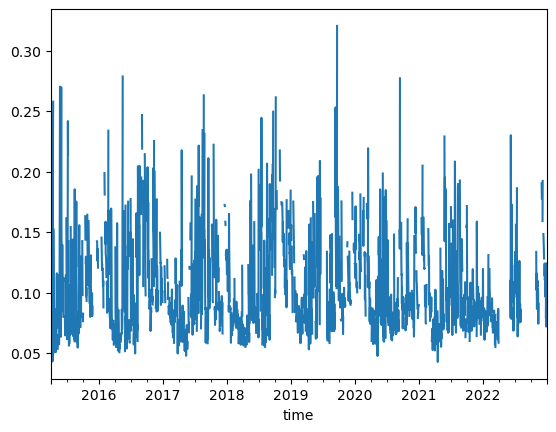

In [24]:
# Merge the AM and PM soil moisture data into one daily timeseries of data
df['soil_moisture_daily'] = df[['Soil_Moisture_Retrieval_Data_AM_soil_moisture','Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df.soil_moisture_daily.plot()

### SMAPL4 Precipitation data ---- skip for now

In [25]:
filename = os.path.join(data_dir, datarods_dir, SMAPL4_path, f"SPL4SMGP_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_p = pd.read_csv(filename).drop(columns=['x','y']).rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_p

,time,precip
0,2015-03-30,0.000000e+00
1,2015-03-31,3.981089e-07
2,2015-04-01,2.236585e-08
3,2015-04-02,1.862578e-12
4,2015-04-03,1.415172e-14
...,...,...
2553,2022-03-26,4.146099e-25
2554,2022-03-27,4.673907e-22
2555,2022-03-28,2.186128e-14
2556,2022-03-29,8.013448e-13


In [26]:

df_p['time'] = pd.to_datetime(df_p['time'])
df_p.set_index('time', inplace=True)
df_p


,precip
time,
2015-03-30,0.000000e+00
2015-03-31,3.981089e-07
2015-04-01,2.236585e-08
2015-04-02,1.862578e-12
2015-04-03,1.415172e-14
...,...
2022-03-26,4.146099e-25
2022-03-27,4.673907e-22
2022-03-28,2.186128e-14


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [27]:
df_p.precip = df_p.precip * 86400

In [31]:
df_sync = pd.merge(df, df_p, how='inner', left_index=True, right_index=True)

df_sync['noprecip'] = df_sync['precip'] < 0.2 # < 0.00002 # Check this threshold 

df_sync.head()

,Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_PM_surface_flag_pm,Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag,Soil_Moisture_Retrieval_Data_AM_soil_moisture,Soil_Moisture_Retrieval_Data_AM_surface_flag,soil_moisture_daily,precip,noprecip
time,,,,,,,,,
2015-03-31,7.0,NaN,2047.0,7.0,NaN,2047.0,NaN,3.439661e-02,True
2015-04-01,7.0,NaN,2047.0,0.0,0.120143,0.0,0.120143,1.932410e-03,True
2015-04-02,0.0,0.102110,0.0,7.0,NaN,2047.0,0.102110,1.609267e-07,True
2015-04-03,0.0,0.089467,0.0,0.0,0.107347,0.0,0.098407,1.222709e-09,True
2015-04-04,7.0,NaN,2047.0,0.0,0.092646,0.0,0.092646,2.140589e-03,True


In [32]:
df_sync.tail()

,Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_PM_surface_flag_pm,Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag,Soil_Moisture_Retrieval_Data_AM_soil_moisture,Soil_Moisture_Retrieval_Data_AM_surface_flag,soil_moisture_daily,precip,noprecip
time,,,,,,,,,
2022-03-26,0.0,0.082154,0.0,7.0,NaN,2047.0,0.082154,3.582230e-20,True
2022-03-27,7.0,NaN,2047.0,0.0,0.061204,0.0,0.061204,4.038256e-17,True
2022-03-28,0.0,0.079170,0.0,7.0,NaN,2047.0,0.079170,1.888815e-09,True
2022-03-29,0.0,0.093700,0.0,0.0,0.079417,0.0,0.086559,6.923619e-08,True
2022-03-30,7.0,NaN,2047.0,0.0,0.073659,0.0,0.073659,1.624048e-01,True


<Axes: xlabel='time'>

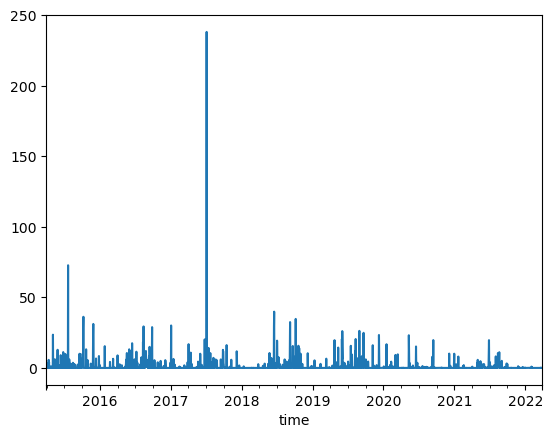

In [33]:
df_sync['precip'].plot()

### PET data

In [36]:
filename = os.path.join(data_dir, datarods_dir, PET_dir, f"PET_{EASE_row_index:03d}_{EASE_column_index:03d}.csv")
df_pet = pd.read_csv(filename).drop(columns=['x','y']) #.rename({'precipitation_total_surface_flux': 'precip'}, axis='columns')
df_pet

,time,pet
0,2020-01-01,2.179536
1,2020-01-02,2.605263
2,2020-01-03,1.521213
3,2020-01-04,2.602938
4,2020-01-05,3.037146
...,...,...
361,2020-12-27,3.339051
362,2020-12-28,2.823386
363,2020-12-29,3.465092
364,2020-12-30,0.915973


In [37]:
df_pet['time'] = pd.to_datetime(df_pet['time'])
df_pet.set_index('time', inplace=True)
df_pet


,pet
time,
2020-01-01,2.179536
2020-01-02,2.605263
2020-01-03,1.521213
2020-01-04,2.602938
2020-01-05,3.037146
...,...
2020-12-27,3.339051
2020-12-28,2.823386
2020-12-29,3.465092


In [38]:
df_sync = pd.merge(df_sync, df_pet, how='inner', left_index=True, right_index=True)
df_sync

,Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm,Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,Soil_Moisture_Retrieval_Data_PM_surface_flag_pm,Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag,Soil_Moisture_Retrieval_Data_AM_soil_moisture,Soil_Moisture_Retrieval_Data_AM_surface_flag,soil_moisture_daily,precip,noprecip,pet
time,,,,,,,,,,
2020-01-01,7.0,NaN,2047.0,0.0,0.123083,0.0,0.123083,1.467880e-09,True,2.179536
2020-01-02,0.0,0.112226,0.0,7.0,NaN,2047.0,0.112226,7.696455e-02,True,2.605263
2020-01-03,0.0,0.128828,0.0,0.0,0.162367,0.0,0.145598,1.057381e+00,False,1.521213
2020-01-04,7.0,NaN,2047.0,0.0,0.170170,0.0,0.170170,0.000000e+00,True,2.602938
2020-01-05,0.0,0.171318,0.0,7.0,NaN,2047.0,0.171318,0.000000e+00,True,3.037146
...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.0,0.083019,0.0,7.0,NaN,2047.0,0.083019,0.000000e+00,True,3.339051
2020-12-28,0.0,0.094688,0.0,0.0,0.084458,0.0,0.089573,6.475666e-08,True,2.823386
2020-12-29,7.0,NaN,2047.0,0.0,0.088909,0.0,0.088909,7.126707e-06,True,3.465092


Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [36]:
# filename = os.path.join(data_dir, PET_dir, f"concat_daily.nc")
# ds_PET = xr.open_dataset(filename)
# ds_PET

<xarray.Dataset>
Dimensions:      (time: 2557, y: 406, x: 964)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
    spatial_ref  int64 ...
  * y            (y) float32 83.63 81.48 79.77 78.3 ... -79.77 -81.48 -83.63
  * x            (x) float32 -179.8 -179.4 -179.1 -178.7 ... 179.1 179.4 179.8
Data variables:
    pet          (time, y, x) float32 ...

In [37]:
# ds_PET_slice = ds_PET.pet.isel(x=EASE_column_index, y=EASE_row_index)

In [40]:
# ds_PET_slice.load().to_dataframe() # Took 6 sec

,spatial_ref,y,x,pet
time,,,,
2015-01-01,0,30.638416,-103.257263,0.702450
2015-01-02,0,30.638416,-103.257263,0.285243
2015-01-03,0,30.638416,-103.257263,2.067308
2015-01-04,0,30.638416,-103.257263,1.265444
2015-01-05,0,30.638416,-103.257263,1.902179
...,...,...,...,...
2021-12-27,0,30.638416,-103.257263,4.575454
2021-12-28,0,30.638416,-103.257263,3.188597
2021-12-29,0,30.638416,-103.257263,2.887350


In [16]:
# Unfortunately this takes a while. I change this to the format of datarods ... 
df_PET = ds_PET.pet.isel(x=EASE_column_index, y=EASE_row_index).to_dataframe().drop(['spatial_ref', 'x', 'y'], axis=1)

In [17]:
ds_synced = pd.merge(df['soil_moisture_daily'], df_PET['pet'], how='outer', left_index=True, right_index=True)
ds_synced.head()

,soil_moisture_daily,pet
time,,
2015-01-01,NaN,0.702450
2015-01-02,NaN,0.285243
2015-01-03,NaN,2.067308
2015-01-04,NaN,1.265444
2015-01-05,NaN,1.902179


In [23]:
ds_synced.tail()

,soil_moisture_daily,pet
time,,
2022-12-27,0.100999,NaN
2022-12-28,0.071899,NaN
2022-12-29,0.099809,NaN
2022-12-30,0.124026,NaN
2022-12-31,NaN,NaN


## Process the datasets

### Calculate dSdt

In [24]:
# Thresholds
precip_thresh = 0.00002

In [25]:
# TODO: put this precip mask back once I've got precip data
# precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
# no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))

# Allow detecting soil moisture increment even if there is no SM data in between before/after rainfall event
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].ffill() 

# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)

In [26]:
ds_synced.loc[ds_synced['soil_moisture_daily'].shift(-1).isna(), 'dSdt'] = np.nan

In [27]:
ds_synced.head()

,soil_moisture_daily,pet,sm_for_dS_calc,dS,dt,dSdt
time,,,,,,
2015-03-31,NaN,NaN,NaN,NaN,2.0,NaN
2015-04-01,0.120143,NaN,0.120143,NaN,1.0,-0.018033
2015-04-02,0.102110,NaN,0.102110,-0.018033,1.0,-0.003703
2015-04-03,0.098407,NaN,0.098407,-0.003703,1.0,-0.005762
2015-04-04,0.092646,NaN,0.092646,-0.005762,1.0,-0.022355


### Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than four SMAP observations were retained.

In [28]:
# Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
max_sm = ds_synced.soil_moisture_daily.max()
min_sm = ds_synced.soil_moisture_daily.min()
sm_range = max_sm - min_sm
dSdt_thresh = sm_range * 0.05

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
target_rmsd = 0.08
dSdt_thresh

0.013886867150000003

In [29]:
ds_synced.head(10)

,soil_moisture_daily,pet,sm_for_dS_calc,dS,dt,dSdt
time,,,,,,
2015-03-31,NaN,NaN,NaN,NaN,2.0,NaN
2015-04-01,0.120143,NaN,0.120143,NaN,1.0,-0.018033
2015-04-02,0.102110,NaN,0.102110,-0.018033,1.0,-0.003703
2015-04-03,0.098407,NaN,0.098407,-0.003703,1.0,-0.005762
2015-04-04,0.092646,NaN,0.092646,-0.005762,1.0,-0.022355
2015-04-05,0.070291,NaN,0.070291,-0.022355,1.0,0.022505
2015-04-06,0.092796,NaN,0.092796,0.022505,1.0,NaN
2015-04-07,NaN,NaN,0.092796,0.000000,1.0,-0.026975
2015-04-08,0.065821,NaN,0.065821,-0.026975,1.0,0.006550


In [30]:
negative_increments = ds_synced.dSdt < 0

# To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
positive_increments = ds_synced.dSdt > target_rmsd

In [31]:
# TODO: NOT lose drydown starting after NaN

# Negative dSdt preceded with positive dSdt
ds_synced['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
ds_synced['event_start'][ds_synced['event_start']].index

DatetimeIndex(['2015-04-11', '2015-07-07', '2015-08-15', '2016-02-01',
               '2016-03-10', '2016-04-13', '2016-08-10', '2016-08-19',
               '2016-11-04', '2017-04-17', '2017-07-14', '2017-09-16',
               '2017-10-16', '2017-10-31', '2017-12-18', '2018-01-12',
               '2018-05-15', '2018-05-18', '2018-06-05', '2018-07-16',
               '2018-08-17', '2018-09-02', '2019-01-14', '2019-04-14',
               '2019-06-01', '2019-06-15', '2019-09-12', '2019-10-16',
               '2019-12-17', '2020-03-09', '2020-03-16', '2020-05-24',
               '2020-06-08', '2020-06-25', '2021-05-26', '2021-06-22',
               '2021-11-27', '2022-06-09', '2022-06-15', '2022-12-02'],
              dtype='datetime64[ns]', name='time', freq=None)

### Iterate through each row to find event end

In [32]:
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)

for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                None
            # TODO: putthis threshold back once Ive got precip data
            #or ds_synced['precip'][j] > precip_thresh:
            if ds_synced['dS'][j] >= dSdt_thresh: 
                # Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded (if there is not precipitation) if it would otherwise truncate a drydown. 
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end
ds_synced['event_end'] = ds_synced['event_end'].shift(-1)
ds_synced = ds_synced[:-1]
ds_synced['event_start'][ds_synced['event_end']].index
ds_synced['dSdt(t-1)'] = ds_synced.dSdt.shift(+1)

/tmp/ipykernel_3143380/2432228680.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ds_synced['event_start'][i]:
/tmp/ipykernel_3143380/2432228680.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isnan(ds_synced['dS'][j]):
/tmp/ipykernel_3143380/2432228680.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ds_synced['dS'][j] >= dSdt_thresh:


### Get normalized SM

In [33]:
ds_synced['normalized_S'] = (ds_synced.soil_moisture_daily - min_sm)/(max_sm - min_sm)
ds_synced.head(10)

,soil_moisture_daily,pet,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1),normalized_S
time,,,,,,,,,,
2015-03-31,NaN,NaN,NaN,NaN,2.0,NaN,False,False,NaN,NaN
2015-04-01,0.120143,NaN,0.120143,NaN,1.0,-0.018033,False,False,NaN,0.278894
2015-04-02,0.102110,NaN,0.102110,-0.018033,1.0,-0.003703,False,False,-0.018033,0.213966
2015-04-03,0.098407,NaN,0.098407,-0.003703,1.0,-0.005762,False,False,-0.003703,0.200634
2015-04-04,0.092646,NaN,0.092646,-0.005762,1.0,-0.022355,False,False,-0.005762,0.179889
2015-04-05,0.070291,NaN,0.070291,-0.022355,1.0,0.022505,False,False,-0.022355,0.099399
2015-04-06,0.092796,NaN,0.092796,0.022505,1.0,NaN,False,False,0.022505,0.180429
2015-04-07,NaN,NaN,0.092796,0.000000,1.0,-0.026975,False,False,NaN,NaN
2015-04-08,0.065821,NaN,0.065821,-0.026975,1.0,0.006550,False,False,-0.026975,0.083306


### Plot

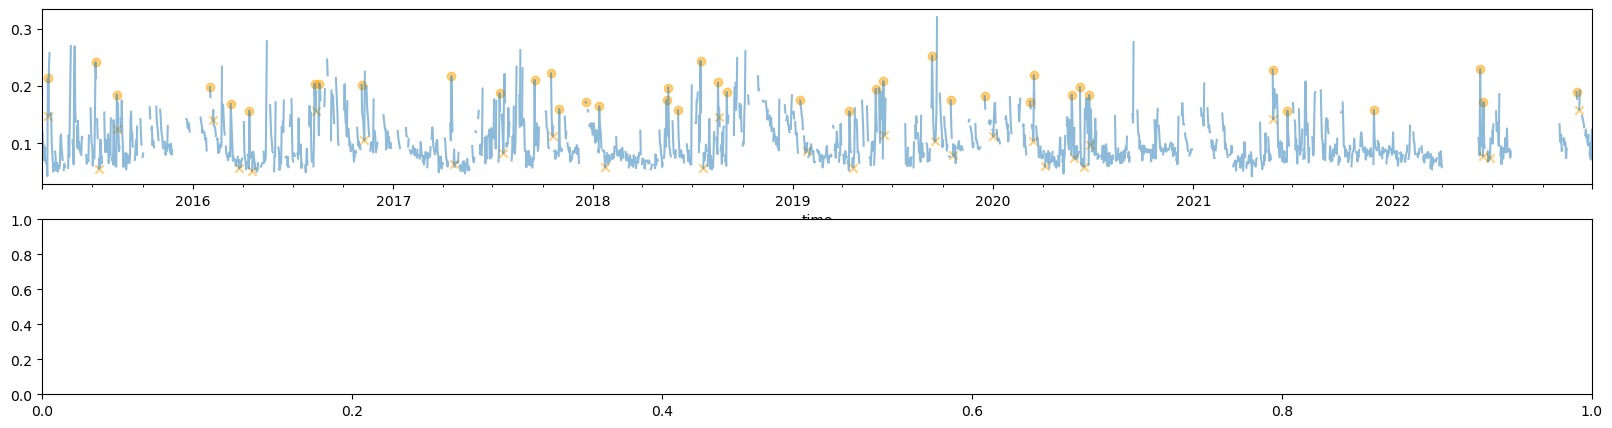

In [34]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
# ds_synced.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_timeseries.png'))

### Close-up

(17897.0, 18260.0)

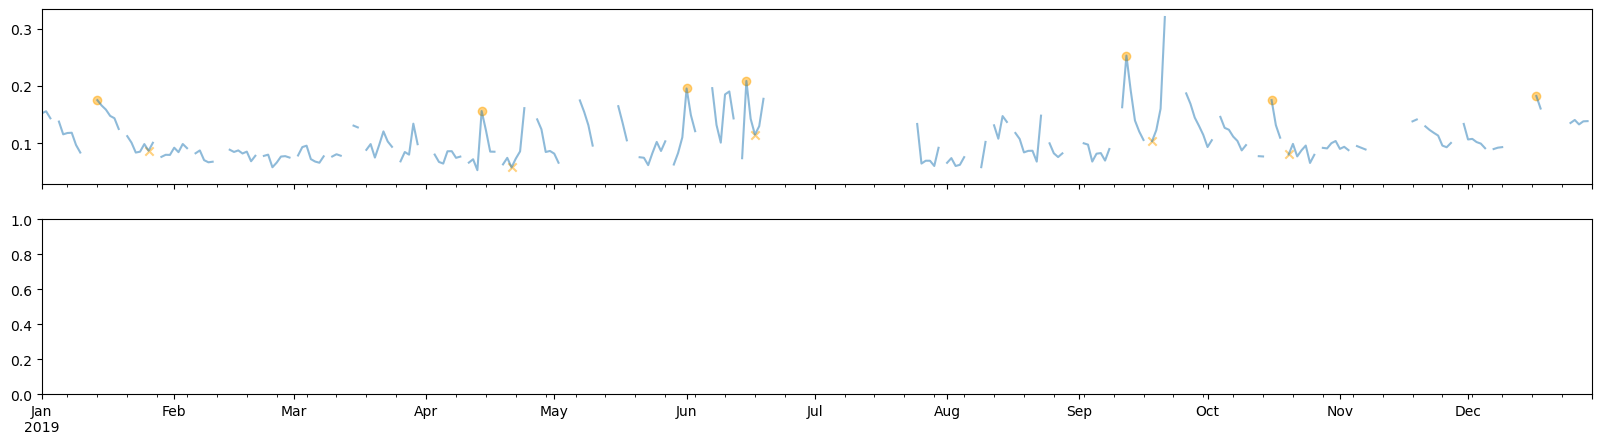

In [35]:
fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
# ds_synced.precip.plot(ax=ax22, alpha=0.5)

ax22.set_xlim([datetime(2019, 1, 1), datetime(2019, 12, 30)])

### Separate into events

In [36]:
start_indices = ds_synced[ds_synced['event_start']].index
end_indices = ds_synced[ds_synced['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(ds_synced.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'normalized_S': list(ds_synced.loc[start_index:end_index, 'normalized_S'].values),
               # 'precip': list(ds_synced.loc[start_index:end_index, 'precip'].values),
               'PET': list(ds_synced.loc[start_index:end_index, 'pet'].values),
               #'LAI': list(ds_synced.loc[start_index:end_index, 'LAI'].values),
               #'NDVI': list(ds_synced.loc[start_index:end_index, 'NDVI'].values),
               'delta_theta': ds_synced.loc[start_index, 'dSdt(t-1)'],
                #'bulk_density': ds_synced.loc[start_index, 'bulk_density'],
                #'sand_fraction': ds_synced.loc[start_index, 'sand_fraction'],
                #'clay_fraction': ds_synced.loc[start_index, 'clay_fraction']
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

In [37]:
min_consective_days = 5
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= min_consective_days].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long

,event_start,event_end,soil_moisture_daily,normalized_S,PET,delta_theta
0,2015-07-07,2015-07-13,"[0.24176873, 0.2141779, nan, 0.14256175, 0.109...","[0.7168106054791487, 0.6174691568213064, nan, ...","[nan, nan, nan, nan, nan, nan, nan]",0.092073
1,2016-03-10,2016-03-25,"[0.16945308, 0.14320925, 0.11525308249999999, ...","[0.4564363640506202, 0.36194482137031175, 0.26...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.091895
2,2016-04-13,2016-04-18,"[0.157387945, 0.08932383, 0.07458029, 0.084044...","[0.4129955545805016, 0.16792906742828603, 0.11...","[nan, nan, nan, nan, nan, nan]",0.100752
3,2016-11-04,2016-11-09,"[0.20237754, 0.15177824, 0.14819707, 0.1399147...","[0.574981676122681, 0.3927976764723352, 0.3799...","[nan, nan, nan, nan, nan, nan]",0.112206
4,2017-07-14,2017-07-21,"[0.18805091, 0.15733178, nan, nan, 0.1502634, ...","[0.5233982993781285, 0.4127933311438066, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan]",0.098036
5,2017-10-31,2017-11-06,"[0.16017655, 0.098678574, 0.08828106, 0.091423...","[0.4230359941190911, 0.2016110487526339, 0.164...","[nan, nan, nan, nan, nan, nan, nan]",0.081810
6,2017-12-18,2018-01-01,"[0.17248945, 0.17150131, nan, nan, 0.15858634,...","[0.46736888744557475, 0.46381106555051893, nan...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.106347
7,2018-01-12,2018-01-23,"[0.16504511, 0.13690972, 0.12726162, 0.1135434...","[0.4405653617850013, 0.33926321171726626, 0.30...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.080887
8,2018-05-18,2018-05-25,"[0.19756052, 0.14103073, 0.09505274, 0.0900812...","[0.5576378794694524, 0.3541010075839891, 0.188...","[nan, nan, nan, nan, nan, nan, nan, nan]",0.083779
9,2018-06-05,2018-06-20,"[0.15816964, 0.112377593, 0.09522355, 0.076401...","[0.41581006627545936, 0.2509346969593498, 0.18...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.081323


## Fit models to drydown curve

### Calculate tau & q

In [38]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

### Expontnetial model

In [39]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll

In [40]:
# Fit exponential model to each drydown event
opt_model = 'OLSE'
drydown_params = []

for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['normalized_S'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]

    # Define the bounds
    # exp_model(t, delta_theta, theta_w, tau):
    bounds  = [(0, min_sm, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
    p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm)/2, 1]
    try: 
        # Fit the data
        popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = exp_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        
    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

An error occurred: Each lower bound must be strictly less than each upper bound.


,event_start,event_end,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-07-07,2015-07-13,0.715536,0.042684,3.124497,0.945287,"[0.7582198372983063, 0.5622428216294808, 0.316..."
1,2016-03-10,2016-03-25,0.408815,0.051568,2.926272,0.939433,"[0.46038355723514174, 0.34204746134379277, 0.2..."
2,2016-11-04,2016-11-09,0.357936,0.197239,2.697772,0.923789,"[0.5551759183331377, 0.44431130446784756, 0.36..."
3,2017-07-14,2017-07-21,0.472799,0.042684,7.281320,0.829302,"[0.5154826287996634, 0.4548110685827327, 0.315..."
4,2017-10-31,2017-11-06,0.266097,0.156769,0.571483,0.990914,"[0.42286537447261585, 0.2030170571224366, 0.16..."


In [41]:
# This is also my attempt to use the minnimize function in 
    # # opt_model = 'MLE'
    # if opt_model == "MLE":
    #     bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
    #     p0      = [0.5*soil_moisture_subset_max, (min_sm_values_at_the_pt+soil_moisture_subset_min)/2, 1, 0.1]
    #     res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
    #     popt = res.x
    #     if res.success and res.fun < 0:
    #         drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})

In [42]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit.head()

,event_start,event_end,soil_moisture_daily,normalized_S,PET,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-07-07,2015-07-13,"[0.24176873, 0.2141779, nan, 0.14256175, 0.109...","[0.7168106054791487, 0.6174691568213064, nan, ...","[nan, nan, nan, nan, nan, nan, nan]",0.092073,0.042684,3.124497,0.945287,"[0.7582198372983063, 0.5622428216294808, 0.316..."
1,2016-03-10,2016-03-25,"[0.16945308, 0.14320925, 0.11525308249999999, ...","[0.4564363640506202, 0.36194482137031175, 0.26...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.091895,0.051568,2.926272,0.939433,"[0.46038355723514174, 0.34204746134379277, 0.2..."
2,2016-04-13,2016-04-18,"[0.157387945, 0.08932383, 0.07458029, 0.084044...","[0.4129955545805016, 0.16792906742828603, 0.11...","[nan, nan, nan, nan, nan, nan]",0.100752,NaN,NaN,NaN,NaN
3,2016-11-04,2016-11-09,"[0.20237754, 0.15177824, 0.14819707, 0.1399147...","[0.574981676122681, 0.3927976764723352, 0.3799...","[nan, nan, nan, nan, nan, nan]",0.112206,0.197239,2.697772,0.923789,"[0.5551759183331377, 0.44431130446784756, 0.36..."
4,2017-07-14,2017-07-21,"[0.18805091, 0.15733178, nan, nan, 0.1502634, ...","[0.5233982993781285, 0.4127933311438066, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan]",0.098036,0.042684,7.281320,0.829302,"[0.5154826287996634, 0.4548110685827327, 0.315..."


### q model

In [43]:
def q_model(t, k, q, delta_theta, theta_star, theta_w):

    s0 = (delta_theta - theta_w)**(1-q)

    a = (1 - q) / ( ( theta_star - theta_w ) ** q )

    return (- k * a * t + s0 ) ** (1/(1-q)) + theta_w

In [44]:
drydown_params = []
for index, row in event_df_long.iterrows():
    
    # Read the data
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['normalized_S'])
    PET = 10 #np.average(row['PET']) # TODO: fix this as observed PET after getting the dataset
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    
    # Define the bounds
    # q_model(t, k, q, delta_theta, theta_star, theta_w=0)
    # custom_q_model = lambda x, mu: q_model(x, mu, 0.05)
    epsilon = 1.0E-10
    bounds  = [(0., 0., 0., 0., 0), (PET*10, 10, 1., 1., 1.)]
    p0      = [PET, 1. + 1.E-03, soil_moisture_range, 0.5, 1.0E-5]
    
    try: 
        # Fit the model
        popt, pcov = curve_fit(f=q_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
        # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
        # pcov: The estimated covariance of popt
        
        # Reroduce the analytical solution and calculate the residuals
        y_opt = q_model(x, *popt)
        residuals = y - y_opt
        ss_res = np.sum(residuals ** 2)
        ss_tot = np.sum((y - np.nanmean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Save
        drydown_params.append({'event_start': start_date, 'event_end': end_date, 'q__k': popt[0], 'q__q': popt[1], 'q__delta_theta': popt[2], 'q__theta_star': popt[3], 'q__theta_w': popt[4], 'q__r_squared': r_squared, 'q__opt_drydown': y_opt.tolist()})

    except Exception as e:
        print("An error occurred:", e)
        continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params_df.head()

/tmp/ipykernel_3143380/4022162658.py:7: RuntimeWarning: invalid value encountered in power
  return (- k * a * t + s0 ) ** (1/(1-q)) + theta_w
/home/raraki/miniconda3/envs/SMAP/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/ipykernel_3143380/4022162658.py:3: RuntimeWarning: invalid value encountered in scalar power
  s0 = (delta_theta - theta_w)**(1-q)


An error occurred: array must not contain infs or NaNs
An error occurred: array must not contain infs or NaNs


,event_start,event_end,q__k,q__q,q__delta_theta,q__theta_star,q__theta_w,q__r_squared,q__opt_drydown
0,2015-07-07,2015-07-13,0.132196,1.136251e-01,0.728123,0.955199,4.770214e-02,0.998612,"[0.7281230388794957, 0.6016209361853534, 0.358..."
1,2016-03-10,2016-03-25,0.316144,8.329900e-01,0.471435,0.998315,8.417183e-02,0.962895,"[0.47143462860299146, 0.34038180254963335, 0.2..."
2,2016-04-13,2016-04-18,4.864747,2.516374e+00,0.412508,0.883996,2.738960e-20,0.948398,"[0.4125083935830698, 0.17636998497544462, 0.12..."
3,2016-11-04,2016-11-09,0.661602,3.092085e+00,0.569040,0.809374,6.817974e-19,0.938581,"[0.5690404632319044, 0.42758500993663906, 0.35..."
4,2017-07-14,2017-07-21,0.045252,1.438383e-13,0.512140,0.682136,7.097716e-02,0.884643,"[0.512139893324528, 0.46688744135785276, 0.331..."


In [45]:
event_df_with_curvefit = pd.merge(event_df_with_curvefit, drydown_params_df, on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit.head()

,event_start,event_end,soil_moisture_daily,normalized_S,PET,delta_theta,theta_w,tau,r_squared,opt_drydown,q__k,q__q,q__delta_theta,q__theta_star,q__theta_w,q__r_squared,q__opt_drydown
0,2015-07-07,2015-07-13,"[0.24176873, 0.2141779, nan, 0.14256175, 0.109...","[0.7168106054791487, 0.6174691568213064, nan, ...","[nan, nan, nan, nan, nan, nan, nan]",0.092073,0.042684,3.124497,0.945287,"[0.7582198372983063, 0.5622428216294808, 0.316...",0.132196,1.136251e-01,0.728123,0.955199,4.770214e-02,0.998612,"[0.7281230388794957, 0.6016209361853534, 0.358..."
1,2016-03-10,2016-03-25,"[0.16945308, 0.14320925, 0.11525308249999999, ...","[0.4564363640506202, 0.36194482137031175, 0.26...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.091895,0.051568,2.926272,0.939433,"[0.46038355723514174, 0.34204746134379277, 0.2...",0.316144,8.329900e-01,0.471435,0.998315,8.417183e-02,0.962895,"[0.47143462860299146, 0.34038180254963335, 0.2..."
2,2016-04-13,2016-04-18,"[0.157387945, 0.08932383, 0.07458029, 0.084044...","[0.4129955545805016, 0.16792906742828603, 0.11...","[nan, nan, nan, nan, nan, nan]",0.100752,NaN,NaN,NaN,NaN,4.864747,2.516374e+00,0.412508,0.883996,2.738960e-20,0.948398,"[0.4125083935830698, 0.17636998497544462, 0.12..."
3,2016-11-04,2016-11-09,"[0.20237754, 0.15177824, 0.14819707, 0.1399147...","[0.574981676122681, 0.3927976764723352, 0.3799...","[nan, nan, nan, nan, nan, nan]",0.112206,0.197239,2.697772,0.923789,"[0.5551759183331377, 0.44431130446784756, 0.36...",0.661602,3.092085e+00,0.569040,0.809374,6.817974e-19,0.938581,"[0.5690404632319044, 0.42758500993663906, 0.35..."
4,2017-07-14,2017-07-21,"[0.18805091, 0.15733178, nan, nan, 0.1502634, ...","[0.5233982993781285, 0.4127933311438066, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan]",0.098036,0.042684,7.281320,0.829302,"[0.5154826287996634, 0.4548110685827327, 0.315...",0.045252,1.438383e-13,0.512140,0.682136,7.097716e-02,0.884643,"[0.512139893324528, 0.46688744135785276, 0.331..."


### Plot and save

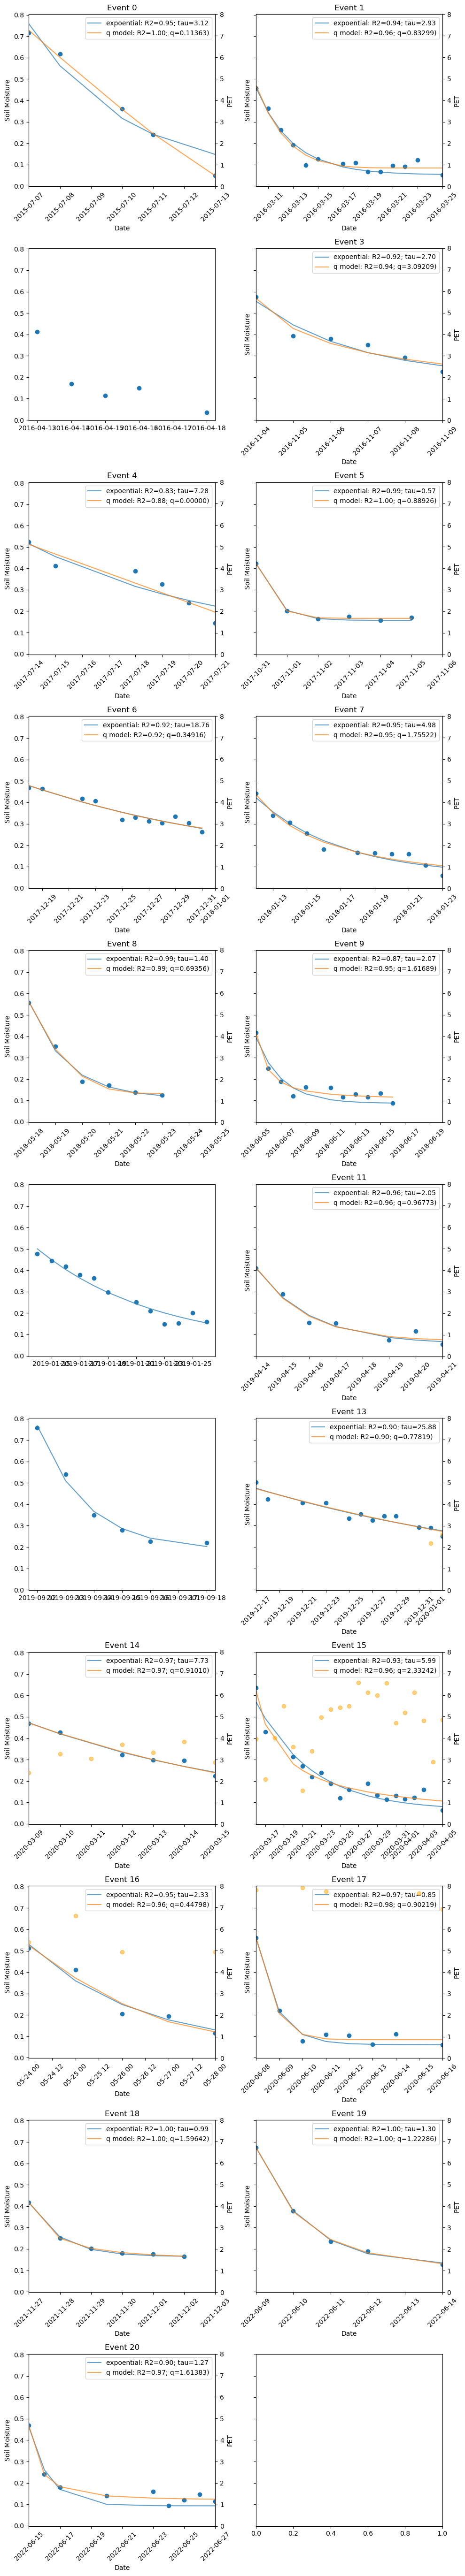

In [46]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 2
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 5*num_rows))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['normalized_S'])
    y_opt = np.asarray(row['opt_drydown'])
    y_opt__q = np.asarray(row['q__opt_drydown'])
    y2 = row['PET']
    t = np.arange(0, len(row['normalized_S']),1)
    r_squared = row['r_squared']
    q__r_squared = row['q__r_squared']
    q = row['q__q']
    tau = row['tau']
    try:
        ax_row = int(index / num_cols)
        ax_col = index % num_cols
        axes[ax_row, ax_col].scatter(x, y)
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7, label=f'expoential: R2={r_squared:.2f}; tau={tau:.2f}')
        axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=f'q model: R2={q__r_squared:.2f}; q={q:.5f})')
        ax2 = axes[ax_row, ax_col].twinx()
        ax2.scatter(x, y2, color='orange', alpha=.5)
        axes[ax_row, ax_col].set_title(f'Event {index}')
        axes[ax_row, ax_col].set_xlabel('Date')
        axes[ax_row, ax_col].set_ylabel('Soil Moisture')
        axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
        axes[ax_row, ax_col].legend()
        ax2.set_ylim([0, 8])
        ax2.set_ylabel('PET')
        # Rotate the x tick labels
        axes[ax_row, ax_col].tick_params(axis='x', rotation=45)
    except:
        try:
            ax_row = int(index / num_cols)
            ax_col = index % num_cols
            axes[ax_row].scatter(x, y)
            axes[ax_row].plot(x[~np.isnan(y)], y_opt, alpha=.7, label=f'expoential: R2={r_squared:.2f}; tau={tau:.2f}')
            axes[ax_row].plot(x[~np.isnan(y)], y_opt__q, alpha=.7, label=f'q model: R2={q__r_squared:.2f}; q={q:.5f})')
            ax2 = axes[ax_row].twinx()
            ax2.scatter(x, y2, color='orange', alpha=.5)
            axes[ax_row].set_title(f'Event {index}')
            axes[ax_row].set_xlabel('Date')
            axes[ax_row].set_ylabel('Soil Moisture')
            axes[ax_row].set_xlim([row['event_start'], row['event_end']])
            ax2.set_ylim([0, 8])
            ax2.set_ylabel('PET')
            # Rotate the x tick labels
            axes[ax_row].tick_params(axis='x', rotation=45)
        except:
            continue
        continue

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_curvefit.png'))

In [47]:
event_df_with_curvefit.to_csv(os.path.join(output_dir, f'pt_{EASE_row_index:03d}_{EASE_column_index:03d}_curvefit.csv'), index=True)